# Create context-specific models using REDS RBC Omics data
## Setup
### Import packages

In [1]:
from pathlib import Path

import gurobipy as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn as mpl_venn
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
from cobra.flux_analysis import find_blocked_reactions
from rbc_gem_utils import (
    ANALYSIS_PATH,
    COBRA_CONFIGURATION,
    PROCESSED_PATH,
    ROOT_PATH,
    GEM_NAME,
    read_cobra_model,
    show_versions,
    write_cobra_model,
)
from rbc_gem_utils.analysis.overlay import (
    ProteinDilution,
    add_relaxation_budget,
    load_overlay_model,
    update_slack_value,
)
from rbc_gem_utils.util import AVOGADRO_NUMBER, DEFAULT_DRY_MASS_PER_CELL
from sklearn.metrics import r2_score

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)

# Show versions of notebook
show_versions()

Set parameter Username

Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Informat

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
COBRA_CONFIGURATION.bounds = (-1e8, 1e8)
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-100000000.0
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Load RBC-GEM model

In [3]:
model_id = "RBC_GEM"

data_path = (ROOT_PATH / ANALYSIS_PATH / "OVERLAY").resolve()
results_path = (ROOT_PATH / PROCESSED_PATH / model_id / "OVERLAY").resolve()
results_path.mkdir(exist_ok=True, parents=True)

save_figures = True
transparent = False
imagetype = "svg"


dataset_name = "REDS_RBCOmics"
pcmodel_dirpath = data_path / model_id
dataset_results_path = results_path / dataset_name
dataset_results_path.mkdir(exist_ok=True)
dataset_sample_models_dirpath = dataset_results_path / "pcmodels_samples"

model = read_cobra_model(filename=pcmodel_dirpath / f"{model_id}.xml")
pcmodel = load_overlay_model(filename=pcmodel_dirpath / f"{model_id}_PC.xml")

pcmodel

Name,RBC_GEM_PC
Memory address,1555576d0
Number of metabolites,10410
Number of reactions,18799
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


## Load RBC Proteomics

In [4]:
# Ensure index corresponds to sample IDs and columns are proteins IDs
df_copy_numbers_per_sample = pd.read_csv(
    data_path / dataset_name / f"{dataset_name}_CopyNumbers.tsv", sep="\t", index_col=0
)
sample_ids = df_copy_numbers_per_sample.index
df_copy_numbers_per_sample

,A0A075B6I0,A0A075B6I9,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6R2,A0A075B6S5,A0A075B6S9,A0A087WSY6,A0A0A0MRZ8,...,Q9Y639,Q9Y666,Q9Y696,Q9Y6B6,Q9Y6B7,Q9Y6E0,Q9Y6I3,Q9Y6M4,Q9Y6M5,Q9Y6R7
S001_D10,114518.643899,63113.250142,17612.721227,1033.70001,250738.681069,0.000000,8828.312669,0.000000,323739.751835,61753.957120,...,1392.454161,0.000000,19954.371068,74758.901488,0.000000,7907.492758,4904.162257,0.000000,8864.838390,4551.934758
S001_D23,83733.413360,17891.485645,0.000000,0.00000,225441.984974,0.000000,28274.865365,138922.828686,323562.039664,63871.782876,...,933.842764,0.000000,11790.361238,0.000000,0.000000,8105.404114,31344.509782,5002.350276,8154.842476,4346.295603
S001_D42,124576.860801,51427.456139,64512.914721,0.00000,232622.665201,0.000000,26229.595680,0.000000,307083.059312,85379.086435,...,2177.042354,161.034294,11937.380407,80634.321987,1094.445937,11943.564971,4265.520169,5596.879103,6604.146775,4345.806113
S002_D10,0.000000,0.000000,0.000000,0.00000,246593.949891,10651.008268,22270.446851,0.000000,0.000000,11125.538105,...,3323.982341,0.000000,21133.854588,46229.818435,0.000000,11718.406394,0.000000,0.000000,23386.405820,5267.201961
S002_D23,52980.619738,0.000000,415956.112710,0.00000,443011.906351,0.000000,0.000000,0.000000,0.000000,0.000000,...,2508.714731,4267.543219,17838.394210,6541.070445,0.000000,16618.381242,0.000000,0.000000,24665.939736,1729.727805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S609_D23,0.000000,0.000000,0.000000,0.00000,225635.007425,0.000000,9092.998956,0.000000,60754.867934,40445.049243,...,3673.791044,0.000000,7148.104570,124188.370607,0.000000,8157.254438,3839.757297,6371.901194,15905.183729,2299.903991
S609_D42,0.000000,0.000000,0.000000,0.00000,138221.840018,0.000000,4613.159040,0.000000,88833.464684,20512.080999,...,3465.156142,0.000000,7107.225657,60512.211739,0.000000,9264.103912,10641.041401,897037.392699,13430.857197,3605.287383
S610_D10,52483.854665,0.000000,16017.273082,0.00000,149738.028981,14758.092712,10439.649393,39609.443748,0.000000,20907.088540,...,3964.128687,0.000000,0.000000,22176.084986,0.000000,10180.734600,6533.999663,7128.257654,7239.240669,1943.954949
S610_D23,54229.883559,0.000000,0.000000,0.00000,93055.342976,0.000000,12750.686038,86361.815849,200688.996186,134584.998264,...,2734.603592,0.000000,17318.853805,82170.719021,0.000000,8004.910478,2869.029393,5507.615399,9508.849456,4726.448375


In [5]:
# Expected Sample IDs are given as S[0-9][0-9][0-9]D[10,21,42]
sample_prefix, time_prefix = ("S", "D")
# Integers are easier to work with for time points
timepoints = [10, 23, 42]

def get_sample_from_id(model_id, sample_prefix=""):
    sample = model_id.rsplit("_", 2)[-2]
    try:
        return int(sample.replace(sample_prefix, ""))
    except ValueError:
        return sample


def get_time_from_id(model_id, time_prefix=""):
    time = model_id.rsplit("_", 2)[-1]
    try:
        return int(time.replace(time_prefix, ""))
    except ValueError:
        return time

### Get data subsets using operations on data

In [6]:
operations = [
    "mean",
    "median",
    # "min",
    # "max",
]
percentiles = [
    # 0.00, # Minimum
    # 0.10,
    # 0.20, # Quintile 1
    # 0.25, # Quartile 1
    # 0.30,
    # 0.40, # Quintile 2
    # 0.50, # Median, Quartile 2,
    # 0.60, # Quintile 3
    # 0.70,
    # 0.75, # Quartile 3
    # 0.80, # Quintile 4
    # 0.90,
    # 1.00, # Maximum, Quintile 5
]


if operations or percentiles:
    df_operations = []
    for time in timepoints:
        df_time = df_copy_numbers_per_sample.loc[
            [
                x
                for x in df_copy_numbers_per_sample.index
                if get_time_from_id(x, time_prefix) == time
            ]
        ].T
        df_op = pd.concat(
            [getattr(df_time, op.lower())(axis=1) for op in operations], axis=1
        )
        df_op.columns = [f"{op.capitalize()}_{time_prefix}{time}" for op in operations]
        df_operations += [df_op]
        if percentiles:
            df_op = pd.concat(
                [df_time.quantile(percent, axis=1) for percent in percentiles], axis=1
            )
            df_op.columns = [
                f"Percentile{int(round(percent * 100, 0))}_{time_prefix}{time}"
                for percent in percentiles
            ]
            df_operations += [df_op]
    df_operations = pd.concat(df_operations, axis=1)
    operation_ids = df_operations.columns
    df_copy_numbers_per_sample = pd.concat((df_copy_numbers_per_sample.T, df_operations), axis=1)
    df_copy_numbers = df_copy_numbers_per_sample.T
else:
    df_copy_numbers = df_copy_numbers_per_sample.T
    operation_ids = []
df_copy_numbers

,A0A075B6I0,A0A075B6I9,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6R2,A0A075B6S5,A0A075B6S9,A0A087WSY6,A0A0A0MRZ8,...,Q9Y639,Q9Y666,Q9Y696,Q9Y6B6,Q9Y6B7,Q9Y6E0,Q9Y6I3,Q9Y6M4,Q9Y6M5,Q9Y6R7
S001_D10,114518.643899,63113.250142,17612.721227,1033.700010,250738.681069,0.000000,8828.312669,0.000000,323739.751835,61753.957120,...,1392.454161,0.000000,19954.371068,74758.901488,0.000000,7907.492758,4904.162257,0.000000,8864.838390,4551.934758
S001_D23,83733.413360,17891.485645,0.000000,0.000000,225441.984974,0.000000,28274.865365,138922.828686,323562.039664,63871.782876,...,933.842764,0.000000,11790.361238,0.000000,0.000000,8105.404114,31344.509782,5002.350276,8154.842476,4346.295603
S001_D42,124576.860801,51427.456139,64512.914721,0.000000,232622.665201,0.000000,26229.595680,0.000000,307083.059312,85379.086435,...,2177.042354,161.034294,11937.380407,80634.321987,1094.445937,11943.564971,4265.520169,5596.879103,6604.146775,4345.806113
S002_D10,0.000000,0.000000,0.000000,0.000000,246593.949891,10651.008268,22270.446851,0.000000,0.000000,11125.538105,...,3323.982341,0.000000,21133.854588,46229.818435,0.000000,11718.406394,0.000000,0.000000,23386.405820,5267.201961
S002_D23,52980.619738,0.000000,415956.112710,0.000000,443011.906351,0.000000,0.000000,0.000000,0.000000,0.000000,...,2508.714731,4267.543219,17838.394210,6541.070445,0.000000,16618.381242,0.000000,0.000000,24665.939736,1729.727805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Median_D10,85464.622699,0.000000,30748.164825,0.000000,294564.863065,1606.060416,19872.719590,0.000000,0.000000,66367.458999,...,2115.328609,0.000000,15454.186781,18062.564650,0.000000,10663.310665,3695.500756,0.000000,10992.619045,2871.079170
Mean_D23,96669.170765,12209.499520,73634.091807,183.267034,344026.881912,4017.919472,22131.922855,47078.245599,104577.327724,87407.590560,...,2198.195291,239.284800,17627.126338,34902.514611,345.234652,10915.818743,3516.922905,27360.397321,11794.297779,3181.105272
Median_D23,82336.439302,0.000000,24073.542249,0.000000,284796.840456,959.726613,17758.270975,0.000000,0.000000,72207.457164,...,1985.399693,0.000000,15613.970488,16976.149613,0.000000,10559.435662,2769.971458,0.000000,10966.139479,2818.004738
Mean_D42,99419.830802,9975.057849,85180.064209,219.060237,353206.967756,3879.881145,23679.369830,42896.348347,98251.410455,83648.145692,...,2203.077061,224.010745,16351.255299,34612.502336,298.707645,10863.234629,3106.800020,31605.797099,11775.209016,3132.354219


## Integrate proteomics with model
### Convert copy numbers to mg / gDW

In [7]:
df_protein_data = pd.read_csv(
    data_path / dataset_name / f"{dataset_name}_ProteinData.tsv",
    sep="\t",
    index_col="Entry",
)
df_uniprot_to_mw = df_protein_data["Mass"] / 1000  # g/mol --> # kg / mol

df_mg_prot_per_gDW = (
    df_copy_numbers  # protein copies / cell
    * (1 / DEFAULT_DRY_MASS_PER_CELL)  # cell / pgDW
    * (1e12 / 1)  # pgDW / gDW
    * (1 / AVOGADRO_NUMBER)  # mol / protein copies
    * (df_uniprot_to_mw)  # kg / mol
    * (1e6 / 1)  # mg / kg
).copy()
df_mg_prot_per_gDW

,A0A075B6I0,A0A075B6I9,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6R2,A0A075B6S5,A0A075B6S9,A0A087WSY6,A0A0A0MRZ8,...,Q9Y639,Q9Y666,Q9Y696,Q9Y6B6,Q9Y6B7,Q9Y6E0,Q9Y6I3,Q9Y6M4,Q9Y6M5,Q9Y6R7
S001_D10,0.081225,0.043556,0.012100,0.000712,0.171152,0.000000,0.006212,0.000000,0.224602,0.043154,...,0.003421,0.000000,0.031779,0.092733,0.000000,0.021582,0.016367,0.000000,0.027135,0.144123
S001_D23,0.059390,0.012347,0.000000,0.000000,0.153885,0.000000,0.019895,0.097565,0.224479,0.044634,...,0.002294,0.000000,0.018777,0.000000,0.000000,0.022122,0.104606,0.014229,0.024961,0.137612
S001_D42,0.088359,0.035491,0.044322,0.000000,0.158786,0.000000,0.018456,0.000000,0.213046,0.059664,...,0.005349,0.001062,0.019011,0.100021,0.005044,0.032597,0.014235,0.015920,0.020215,0.137596
S002_D10,0.000000,0.000000,0.000000,0.000000,0.168323,0.007575,0.015670,0.000000,0.000000,0.007775,...,0.008167,0.000000,0.033657,0.057345,0.000000,0.031983,0.000000,0.000000,0.071584,0.166770
S002_D23,0.037578,0.000000,0.285770,0.000000,0.302396,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006164,0.028135,0.028409,0.008114,0.000000,0.045356,0.000000,0.000000,0.075501,0.054766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Median_D10,0.060618,0.000000,0.021125,0.000000,0.201068,0.001142,0.013983,0.000000,0.000000,0.046378,...,0.005197,0.000000,0.024612,0.022405,0.000000,0.029103,0.012333,0.000000,0.033648,0.090904
Mean_D23,0.068565,0.008426,0.050588,0.000126,0.234830,0.002857,0.015573,0.033063,0.072553,0.061081,...,0.005401,0.001578,0.028072,0.043294,0.001591,0.029792,0.011737,0.077825,0.036101,0.100720
Median_D23,0.058399,0.000000,0.016539,0.000000,0.194400,0.000683,0.012495,0.000000,0.000000,0.050459,...,0.004878,0.000000,0.024866,0.021058,0.000000,0.028819,0.009244,0.000000,0.033567,0.089223
Mean_D42,0.070516,0.006884,0.058520,0.000151,0.241096,0.002759,0.016661,0.030126,0.068164,0.058454,...,0.005413,0.001477,0.026040,0.042934,0.001377,0.029649,0.010368,0.089901,0.036043,0.099176


### Scale measurements for proteome budget
Note that this step will help ensure its theoretically possible for a perfect fit 

In [8]:
la_proteome_budget_value = 50
hemoglobin_budget_value = 950
total_budget_value = None

In [9]:
# Split into hemoglobin and low abundance proteomes
hb_proteins = {
    # Model Gene: UniProt ID
    "HBA": "P69905",
    "HBB": "P68871",
    "HBD": "P02042",
    "HBM": "Q6B0K9",
    "HBE1": "P02100",
    "HBG1": "P69891",
    "HBG2": "P69892",
    "HBQ1": "P09105",
    "HBZ": "P02008",
}
df_mg_prot_per_gDW_hb = df_mg_prot_per_gDW.loc[:, list(hb_proteins.values())]
df_mg_prot_per_gDW_la = df_mg_prot_per_gDW.loc[
    :, [x for x in df_mg_prot_per_gDW.columns if not x in list(hb_proteins.values())]
]

df_summary = {
    "Perfect total": 1000,
    "Current total": df_mg_prot_per_gDW.sum(axis=1).mean().item(),
    "Hemoglobin total": df_mg_prot_per_gDW_hb.sum(axis=1).mean().item(),
    "Low abundance total": df_mg_prot_per_gDW_la.sum(axis=1).mean().item(),
}
df_summary["Remaining/Excess"] = (
    df_summary["Perfect total"] - (
        df_summary["Hemoglobin total"]
        + df_summary["Low abundance total"]
    )
)

PBDL_proteome_budget = pcmodel.reactions.get_by_id("PBDL_proteome_budget")
PBDL_hemoglobin_budget = pcmodel.reactions.get_by_id("PBDL_hemoglobin_budget")
PBDL_total_budget = pcmodel.reactions.get_by_id("PBDL_total_budget")

if la_proteome_budget_value is None:
    la_proteome_budget_value = PBDL_proteome_budget.upper_bound
if hemoglobin_budget_value is None:
    hemoglobin_budget_value = PBDL_hemoglobin_budget.upper_bound
if total_budget_value is None:
    total_budget_value = PBDL_total_budget.upper_bound

assert total_budget_value >= (la_proteome_budget_value + hemoglobin_budget_value)

PBDL_proteome_budget.upper_bound = la_proteome_budget_value
PBDL_hemoglobin_budget.upper_bound = hemoglobin_budget_value
PBDL_total_budget.upper_bound = total_budget_value

# Scale values for low abundance proteome
budget_value = la_proteome_budget_value
df_mg_prot_per_gDW_la = (
    budget_value * (df_mg_prot_per_gDW_la.T / df_mg_prot_per_gDW_la.sum(axis=1)).T
)
df_summary["Low abundance scaled"] = budget_value

# Scale values for hemoglobin proteome
budget_value = hemoglobin_budget_value
df_mg_prot_per_gDW_hb = (
    budget_value * (df_mg_prot_per_gDW_hb.T / df_mg_prot_per_gDW_hb.sum(axis=1)).T
)
df_summary["Hemoglobin scaled"] = budget_value

budget_value = total_budget_value - sum(
    [la_proteome_budget_value, hemoglobin_budget_value]
)
df_summary["Remaining scaled"] = budget_value

# Combine dataframes back into one
df_mg_prot_per_gDW_normalized = pd.concat(
    (df_mg_prot_per_gDW_hb, df_mg_prot_per_gDW_la), axis=1
)
df_summary = pd.DataFrame.from_dict(
    {
        " " * max(30-len(k), 0) + k: [
            f"{v:.4f}", 
            f"{v / 1000 * 100:.1f}%"
        ] 
        for k, v in df_summary.items()
    }, 
    orient="index", 
    columns=["mg protein / gDW / cell", "Percentage"]
)
print(df_summary)
df_mg_prot_per_gDW_normalized.sum(axis=1)

                     mg protein / gDW / cell Percentage
       Perfect total               1000.0000     100.0%
       Current total                983.5272      98.4%
    Hemoglobin total                422.9229      42.3%
 Low abundance total                560.6043      56.1%
    Remaining/Excess                 16.4728       1.6%
Low abundance scaled                 50.0000       5.0%
   Hemoglobin scaled                950.0000      95.0%
    Remaining scaled                  0.0000       0.0%


S001_D10      1000.0
S001_D23      1000.0
S001_D42      1000.0
S002_D10      1000.0
S002_D23      1000.0
               ...  
Median_D10    1000.0
Mean_D23      1000.0
Median_D23    1000.0
Mean_D42      1000.0
Median_D42    1000.0
Length: 1836, dtype: float64

### Convert mg / gDW to nmol / gDW

In [10]:
df_nmol_prot_per_gDW = (
    df_mg_prot_per_gDW_normalized  # mg / gDW
    * (1 / df_uniprot_to_mw)  # mol / kg --> mmol / g --> umol / mg
    * (1e3 / 1)  # nmol / umol
).loc[:, df_mg_prot_per_gDW_normalized.columns]
df_nmol_prot_per_gDW = df_nmol_prot_per_gDW.T
df_nmol_prot_per_gDW

,S001_D10,S001_D23,S001_D42,S002_D10,S002_D23,S002_D42,S003_D10,S003_D23,S003_D42,S004_D10,...,S609_D42,S610_D10,S610_D23,S610_D42,Mean_D10,Median_D10,Mean_D23,Median_D23,Mean_D42,Median_D42
P69905,19518.411868,18323.669082,23255.638382,16525.077791,15753.303701,17309.496212,16701.887760,18523.539047,11235.580183,24222.431968,...,20994.021627,20454.088548,22043.251090,17849.833841,16947.284765,16932.177624,17227.434817,17115.429878,17089.539036,16982.022648
P68871,9503.146391,10031.605421,11963.335657,5453.197068,5092.491052,6879.143103,9390.955205,11351.030090,9217.858990,11122.192261,...,12764.616739,14447.172279,9381.567841,17321.920077,10262.502125,10168.886163,10248.283290,10093.613763,10344.217365,10248.933157
P02042,23598.528519,23922.365911,15256.582852,27625.580957,27930.313499,25892.111687,23732.280301,18498.546948,30364.640014,15743.006155,...,15580.189785,21864.215813,20037.847845,21482.263380,24319.561164,24438.485147,24124.046239,24426.119430,24073.204773,24294.680416
Q6B0K9,0.178078,0.000000,0.000000,5.778649,3.638022,7.861473,3.026435,7.725918,9.768908,1.212330,...,2.609220,0.113530,1.384115,0.000000,2.218352,1.398719,2.300124,1.499757,2.772891,1.807972
P02100,2.705134,3.509404,7.697601,4.510245,289.081171,6.809605,17.970784,4.306167,8.942239,4.057600,...,10.828917,4.584667,1.431378,4.406774,26.784603,6.243070,24.112027,5.861416,22.684754,5.869179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6E0,0.038086,0.040313,0.054938,0.062468,0.090008,0.072397,0.045219,0.055560,0.068864,0.042550,...,0.043612,0.048980,0.036313,0.033781,0.054817,0.055661,0.053605,0.054653,0.053757,0.054698
Q9Y6I3,0.023621,0.155896,0.019620,0.000000,0.000000,0.000000,0.029578,0.000000,0.000000,0.016981,...,0.050095,0.031435,0.013015,0.027986,0.021783,0.019290,0.017271,0.014337,0.015374,0.012757
Q9Y6M4,0.000000,0.024880,0.025744,0.000000,0.000000,0.000000,0.000000,0.035888,0.000000,0.027049,...,4.222957,0.034294,0.024984,0.016275,0.137418,0.000000,0.134361,0.000000,0.156402,0.000000
Q9Y6M5,0.042697,0.040559,0.030378,0.124667,0.133595,0.114644,0.050889,0.081279,0.107624,0.036415,...,0.063228,0.034828,0.043135,0.041588,0.056653,0.057380,0.057919,0.056758,0.058270,0.057551


## Create DataFrame for protein dilution reactions

In [11]:
df_model_protein_dilutions = pd.concat(
    (
        pd.Series(
            {g.annotation.get("uniprot"): g.id for g in model.genes}, name="genes"
        ),
        pd.Series(
            {
                protdl.annotation.get("uniprot"): protdl.id
                for protdl in pcmodel.reactions.query(
                    lambda x: isinstance(x, ProteinDilution)
                )
            },
            name="PROTDL",
        ),
    ),
    axis=1,
)
df_model_protein_dilutions.index.name = "uniprot"
df_model_protein_dilutions = df_model_protein_dilutions[
    df_model_protein_dilutions["genes"].isin(model.genes.list_attr("id"))
].sort_values("PROTDL")
df_model_protein_dilutions

,genes,PROTDL
uniprot,,
Q9NPC4,A4GALT,PROTDL_protein_A4GALT_pc
P49588,AARS1,PROTDL_protein_AARS1_pc
Q9NRN7,AASDHPPT,PROTDL_protein_AASDHPPT_pc
O95477,ABCA1,PROTDL_protein_ABCA1_pc
Q8IZY2,ABCA7,PROTDL_protein_ABCA7_pc
...,...,...
P07947,YES1,PROTDL_protein_YES1_pc
Q5W0Z9,ZDHHC20,PROTDL_protein_ZDHHC20_pc
Q9UIJ5,ZDHHC2,PROTDL_protein_ZDHHC2_pc


## Organize samples

In [12]:
df_samples = df_nmol_prot_per_gDW.copy()

# Best to sort by donor, if sample fails solving at any point, only need to redo the n_timepoints associated with sample.
sort_samples_by_donor = True
merge_key = "uniprot"
run_computations = False

# Use this line of code to determine which samples are used.
# Useful for picking up where notebook may have prematurely stopped.
# Set as 0 or less to use all samples
start_from_sample_id = 0
# Set as 0 or less to use only operation samples
# end_on_sample_id = 0
# Set as length of samples to use all samples
end_on_sample_id = len(df_samples)

# Use this line of code to determine which time points are used.
# Comment out to keep all original points defined in samples
timepoints = [10, 23, 42]
df_samples.index.name = merge_key
# Filter out time points
df_samples = df_samples.loc[
    :, [x for x in df_samples.columns if get_time_from_id(x, time_prefix) in timepoints]
]
# Filter out irrelevant samples
df_samples = pd.concat(
    (
        df_samples.loc[
            :,
            [
                x
                for x in sample_ids
                if start_from_sample_id
                <= get_sample_from_id(x, sample_prefix)
                <= end_on_sample_id
                and x in df_samples.columns
            ],
        ],
        df_samples.loc[:, [x for x in df_samples.columns if x in operation_ids]],
    ),
    axis=1,
)

if sort_samples_by_donor:
    df_samples = pd.concat(
        (
            df_samples.loc[
                :,
                sorted(
                    [x for x in df_samples.columns if x not in operation_ids],
                    key=lambda x: (
                        get_sample_from_id(x, sample_prefix),
                        get_time_from_id(x, time_prefix),
                    ),
                ),
            ],
            df_samples.loc[
                :,
                sorted(
                    [x for x in df_samples.columns if x in operation_ids],
                    key=lambda x: get_time_from_id(x, time_prefix),
                ),
            ],
        ),
        axis=1,
    )
else:
    df_samples = pd.concat(
        [
            pd.concat(
                (
                    df_samples.loc[
                        :,
                        sorted(
                            [
                                x
                                for x in df_samples.columns
                                if get_time_from_id(x, time_prefix) == time
                                and x not in operation_ids
                            ],
                            key=lambda x: get_sample_from_id(x, sample_prefix),
                        ),
                    ],
                    df_samples.loc[
                        :,
                        sorted(
                            [
                                x
                                for x in df_samples.columns
                                if get_time_from_id(x, time_prefix) == time
                                and x in operation_ids
                            ],
                        ),
                    ],
                ),
                axis=1,
            )
            for time in timepoints
        ],
        axis=1,
    )

df_samples

,S001_D10,S001_D23,S001_D42,S002_D10,S002_D23,S002_D42,S003_D10,S003_D23,S003_D42,S004_D10,...,S609_D42,S610_D10,S610_D23,S610_D42,Mean_D10,Median_D10,Mean_D23,Median_D23,Mean_D42,Median_D42
uniprot,,,,,,,,,,,,,,,,,,,,,
P69905,19518.411868,18323.669082,23255.638382,16525.077791,15753.303701,17309.496212,16701.887760,18523.539047,11235.580183,24222.431968,...,20994.021627,20454.088548,22043.251090,17849.833841,16947.284765,16932.177624,17227.434817,17115.429878,17089.539036,16982.022648
P68871,9503.146391,10031.605421,11963.335657,5453.197068,5092.491052,6879.143103,9390.955205,11351.030090,9217.858990,11122.192261,...,12764.616739,14447.172279,9381.567841,17321.920077,10262.502125,10168.886163,10248.283290,10093.613763,10344.217365,10248.933157
P02042,23598.528519,23922.365911,15256.582852,27625.580957,27930.313499,25892.111687,23732.280301,18498.546948,30364.640014,15743.006155,...,15580.189785,21864.215813,20037.847845,21482.263380,24319.561164,24438.485147,24124.046239,24426.119430,24073.204773,24294.680416
Q6B0K9,0.178078,0.000000,0.000000,5.778649,3.638022,7.861473,3.026435,7.725918,9.768908,1.212330,...,2.609220,0.113530,1.384115,0.000000,2.218352,1.398719,2.300124,1.499757,2.772891,1.807972
P02100,2.705134,3.509404,7.697601,4.510245,289.081171,6.809605,17.970784,4.306167,8.942239,4.057600,...,10.828917,4.584667,1.431378,4.406774,26.784603,6.243070,24.112027,5.861416,22.684754,5.869179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6E0,0.038086,0.040313,0.054938,0.062468,0.090008,0.072397,0.045219,0.055560,0.068864,0.042550,...,0.043612,0.048980,0.036313,0.033781,0.054817,0.055661,0.053605,0.054653,0.053757,0.054698
Q9Y6I3,0.023621,0.155896,0.019620,0.000000,0.000000,0.000000,0.029578,0.000000,0.000000,0.016981,...,0.050095,0.031435,0.013015,0.027986,0.021783,0.019290,0.017271,0.014337,0.015374,0.012757
Q9Y6M4,0.000000,0.024880,0.025744,0.000000,0.000000,0.000000,0.000000,0.035888,0.000000,0.027049,...,4.222957,0.034294,0.024984,0.016275,0.137418,0.000000,0.134361,0.000000,0.156402,0.000000


### Map samples to model

In [13]:
df_model = (
    df_model_protein_dilutions[["PROTDL"]]
    .merge(df_samples, left_index=True, right_index=True, how="left")
    .set_index("PROTDL")
    .sort_index()
)
no_experimental_measurements = [
    protein_dilution
    for protein_dilution, has_measurement in df_model.isna().all(axis=1).items()
    if has_measurement
]
print(
    f"Model proteins mapped to measurements: {len(df_model) - len(no_experimental_measurements)}"
)
print(f"Model proteins without measurements: {len(no_experimental_measurements)}")
df_model.dropna()

Model proteins mapped to measurements: 524
Model proteins without measurements: 296


,S001_D10,S001_D23,S001_D42,S002_D10,S002_D23,S002_D42,S003_D10,S003_D23,S003_D42,S004_D10,...,S609_D42,S610_D10,S610_D23,S610_D42,Mean_D10,Median_D10,Mean_D23,Median_D23,Mean_D42,Median_D42
PROTDL,,,,,,,,,,,,,,,,,,,,,
PROTDL_protein_AARS1_pc,0.016548,0.016056,0.022910,0.039456,0.030369,0.037975,0.019119,0.008683,0.005173,0.010755,...,0.013004,0.013325,0.013941,0.019050,0.023450,0.022912,0.023007,0.022846,0.022629,0.022434
PROTDL_protein_AASDHPPT_pc,0.105539,0.094642,0.106604,0.023180,0.000000,0.000000,0.000000,0.000000,0.000000,0.111859,...,0.000000,0.029472,0.043749,0.000000,0.011302,0.000000,0.014236,0.000000,0.009493,0.000000
PROTDL_protein_ABCB6_pc,0.157586,0.141928,0.132416,0.094033,0.095336,0.104518,0.176915,0.086452,0.065404,0.139074,...,0.244628,0.126121,0.167983,0.152676,0.138961,0.143539,0.137605,0.143568,0.139101,0.146168
PROTDL_protein_ABCC1_pc,0.014914,0.014828,0.027336,0.000000,0.000000,0.000000,0.013321,0.045371,0.000000,0.017636,...,0.024819,0.014227,0.017264,0.014310,0.023269,0.018586,0.023177,0.020683,0.023980,0.020776
PROTDL_protein_ABCC4_pc,0.042641,0.046250,0.037210,0.056579,0.054304,0.045073,0.051173,0.046281,0.069150,0.051205,...,0.079712,0.037500,0.056196,0.046514,0.053876,0.056682,0.053662,0.056172,0.053455,0.056020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PROTDL_protein_WDR77_pc,0.468144,0.489826,0.485841,0.494281,0.520838,0.477451,0.442753,0.389425,0.376230,0.528052,...,0.595779,0.515413,0.602775,0.539221,0.465451,0.489648,0.470854,0.490252,0.467087,0.489539
PROTDL_protein_WNK1_pc,0.047562,0.055109,0.052594,0.025514,0.037551,0.015743,0.047097,0.049747,0.019674,0.058304,...,0.045948,0.036403,0.054117,0.038883,0.039330,0.040580,0.040162,0.042469,0.039591,0.041362
PROTDL_protein_XPNPEP1_pc,0.110483,0.109043,0.108751,0.115400,0.152629,0.089800,0.117508,0.122700,0.117942,0.096528,...,0.102349,0.108766,0.112095,0.090995,0.125469,0.128446,0.124195,0.127196,0.122530,0.125684


#### Summarize mapping

In [14]:
dataset_proteins = set(df_samples.index)
model_proteins = set(df_model_protein_dilutions.index)

df_mg_prot_per_gDW_hb = df_mg_prot_per_gDW_normalized.loc[:, list(hb_proteins.values())]
df_mg_prot_per_gDW_la = df_mg_prot_per_gDW_normalized.loc[
    :, [x for x in df_mg_prot_per_gDW.columns if not x in list(hb_proteins.values())]
]

df_mapped_mass_la = df_mg_prot_per_gDW_la.loc[
    :, df_mg_prot_per_gDW_la.columns.isin(model_proteins)
].sum(axis=1)
df_unmapped_mass_la = df_mg_prot_per_gDW_la.loc[
    :, ~df_mg_prot_per_gDW_la.columns.isin(model_proteins)
].sum(axis=1)
df_mapped_mass_hb = df_mg_prot_per_gDW_hb.loc[
    :, df_mg_prot_per_gDW_hb.columns.isin(model_proteins)
].sum(axis=1)
df_unmapped_mass_hb = df_mg_prot_per_gDW_hb.loc[
    :, ~df_mg_prot_per_gDW_hb.columns.isin(model_proteins)
].sum(axis=1)

proteomes = {}
round_int = 6
for label, df in zip(
    ["hemoglobin", "low abundance"], [df_mg_prot_per_gDW_hb, df_mg_prot_per_gDW_la]
):
    df_modeled = df.loc[:, df.columns.isin(model_proteins)].sum(axis=1)
    df_remaining = df.loc[:, ~df.columns.isin(model_proteins)].sum(axis=1)
    means = (df_modeled.mean(), df_remaining.mean())
    stdevs = (df_modeled.std(), df_remaining.std())
    proteomes[(label, "modeled")] = round(means[0], round_int)
    proteomes[(label, "remaining")] = round(means[1], round_int)
proteomes = pd.Series(proteomes, name="Mean value across samples")
proteomes.index = [f"Mean {k[0]} mass {k[1]}" for k in proteomes.index]
print(proteomes.head())
proteomes = proteomes[proteomes != 0]

Mean hemoglobin mass modeled         950.000000
Mean hemoglobin mass remaining         0.000000
Mean low abundance mass modeled       25.268238
Mean low abundance mass remaining     24.731762
Name: Mean value across samples, dtype: float64


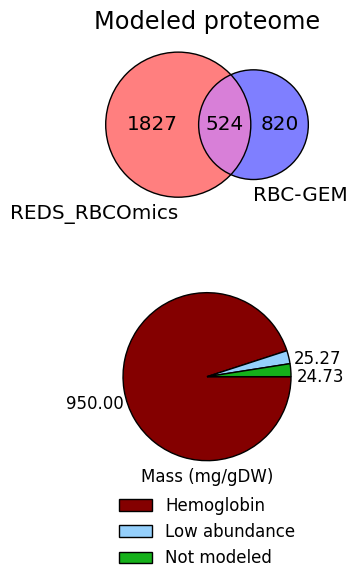

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 6))
subsets = (
    len(dataset_proteins),
    len(model_proteins),
    len(dataset_proteins.intersection(model_proteins)),
)


venn = mpl_venn.venn2(
    subsets=subsets,
    set_labels=(dataset_name, GEM_NAME),
    set_colors=("red", "blue"),
    alpha=0.5,
    ax=ax1,
)
circles = mpl_venn.venn2_circles(
    subsets=subsets, linestyle="-", color="black", ax=ax1, linewidth=1
)
for text in venn.set_labels:
    text.set_fontsize("x-large")
for text in venn.subset_labels:
    text.set_fontsize("x-large")
ax1.set_title("Modeled proteome", fontsize="xx-large")


label_color_map = {
    "Mean hemoglobin mass modeled": ("Hemoglobin", "xkcd:dark red"),
    "Mean low abundance mass modeled": ("Low abundance", "xkcd:light blue"),
    "Mean low abundance mass remaining": ("Not modeled", "xkcd:green"),
}
edgecolor = "black"
linewidth = 1
ax2.pie(
    x=proteomes.values,
    colors=[label_color_map[k][1] for k in proteomes.index],
    pctdistance=1.35,
    counterclock=False,
    autopct=lambda pct: f"{pct * 1000/100:.2f}\n",
    textprops=dict(fontsize="large", ha="center", va="top"),
    wedgeprops=dict(edgecolor=edgecolor, linewidth=linewidth),
)
handles = [
    mpl.patches.Patch(
        edgecolor=edgecolor,
        linewidth=linewidth,
        label=label_color_map[k][0],
        facecolor=label_color_map[k][1],
    )
    for k in proteomes.index
]
ax2.legend(
    handles=handles,
    ncols=1,
    bbox_to_anchor=(0.5, 0),
    loc="upper center",
    fontsize="large",
    frameon=False,
)
ax2.set_xlabel("Mass (mg/gDW)", fontsize="large", labelpad=-10)
if save_figures:
    fig.savefig(
        dataset_results_path / f"ModeledProteome.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig;

### Reduce model using maximum values from proteomics
Create a reduced model using the maximum value measured of each protein across all data samples. By finding the reactions that always remain blocked prior to analysis, the computation time may be reduced.
Also ensure that proteins not found in the dataset don't significantly sway results,

Note: May be problematic if proteins essential for catalysis are not measured. Keep protein bounds unchanged to remove only normal blocked reactions.

In [16]:
remove_blocked_reactions = False

if remove_blocked_reactions:
    pcmodel_blocked = pcmodel.copy()
    df = df_model.max(axis=1)
    for protein_dilution, bound in df.items():
        protein_dilution = pcmodel_blocked.reactions.get_by_id(protein_dilution)
        # if not np.isnan(bound):
        #     protein_dilution.bounds = (0, bound)
        # else:
        #     protein_dilution.bounds = (0, 0)
    blocked = find_blocked_reactions(pcmodel_blocked)
    pcmodel.remove_reactions(blocked, remove_orphans=True)

for objective_reaction in ["NaKt"]:
    objective_reaction = pcmodel.reactions.get_by_id(objective_reaction)
    pcmodel.objective = objective_reaction.flux_expression
    print(pcmodel.slim_optimize())

pcmodel

23.042427752694984


Name,RBC_GEM_PC
Memory address,1555576d0
Number of metabolites,10410
Number of reactions,18799
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


## Create QP model for each sample

In [17]:
def solve_qp(pcmodel, df):
    x = []  # Variables
    c = []  # Data * Weights
    F = []  # Weights

    for protdl, (data_value, weight) in df.iterrows():
        protdl = pcmodel.reactions.get_by_id(protdl)
        x.append(protdl.flux_expression)
        c.append(weight * data_value)
        F.append(weight)

    x = sympy.Matrix(x)
    c = sympy.Matrix(c)
    F = sympy.DiagMatrix(sympy.Matrix(F))
    # # QP Objective must be in form of 0.5 * x.T * F * x - c.T * x
    objective = 0.5 * x.T * F * x - c.T * x
    pcmodel.objective = objective[0]
    pcmodel.objective_direction = "min"
    pcmodel.tolerance = 1e-9

    qp_sol = pcmodel.optimize()
    return qp_sol


def solve_qp_for_samples(pcmodel, df_samples, df_weights=None, verbose=False):
    qp_solutions_dict = {}
    for sample_id, data_series in df_samples.items():
        # Get protein values
        data_series.name = "Data"
        if df_weights is None:
            data_weights = 1 / data_series.replace(0, 1)
            data_weights = data_weights / data_weights.mean()
        else:
            data_weights = df_weights.loc[:, sample_id]
        # Get protein weights
        data_weights.name = "Weights"

        # Map to model, currently model mapping DataFrame generated outside scope of function
        df_model_data_weights = (
            df_model_protein_dilutions[["PROTDL"]]
            .merge(data_series, left_index=True, right_index=True, how="left")
            .merge(data_weights, left_index=True, right_index=True, how="left")
            .set_index("PROTDL")
            .sort_index()
        )

        df = df_model_data_weights.loc[:, [data_series.name, data_weights.name]].dropna(
            axis=0, how="all"
        )

        with pcmodel:
            qp_sol = solve_qp(pcmodel, df)

        df_qp_sol = qp_sol.fluxes.loc[
            pcmodel.reactions.query(lambda x: isinstance(x, ProteinDilution)).list_attr(
                "id"
            )
        ]
        df_qp_sol = (
            pd.concat((df_model_data_weights, df_qp_sol), axis=1).dropna().sort_index()
        )
        # data_weights = df_qp_sol.loc[:, "Weights"]

        df_qp_sol = df_qp_sol.rename(
            {"Data": "Measured Proteome", "fluxes": "Best-Fitted Proteome"}, axis=1
        )
        df_qp_sol = df_qp_sol.loc[:, ["Measured Proteome", "Best-Fitted Proteome"]]

        r2 = r2_score(
            df_qp_sol.iloc[:, 0].values,
            df_qp_sol.iloc[:, 1].values,
            multioutput="uniform_average",
        )
        qp_solutions_dict[sample_id] = (df_qp_sol, r2, qp_sol.objective_value)
        if verbose:
            # Recall that the objective is designed to try to minimize fitting error via maximizing R2, so 1 is a possibility
            print(
                "R^2 (objective) value for Sample '{}': {:.9f} ({:.5f})".format(
                    sample_id, r2, qp_sol.objective_value
                )
            )
        # TODO catch bad fits

    return qp_solutions_dict

### Set weightings for QP problem

In [18]:
# Ensure data is provided as (Protein IDs x Sample IDs)
# Use original measurements for weights
df_weights = df_copy_numbers.T.loc[:, df_samples.columns]
df_weights = 1 / df_weights.replace(0, 1)
df_weights /= df_weights.mean()

In [19]:
fitting_path = dataset_results_path / "fitting"
fitting_path.mkdir(exist_ok=True)

if run_computations:
    qp_solutions_dict = solve_qp_for_samples(
        pcmodel, df_samples, df_weights=df_weights, verbose=True
    )
    df_measured = {}
    df_best_fit = {}
    df_r2_objective = {}
    for sample_id, (df_qp_sol, r2, objective_value) in qp_solutions_dict.items():
        df_measured[sample_id] = df_qp_sol["Measured Proteome"].to_dict()
        df_best_fit[sample_id] = df_qp_sol["Best-Fitted Proteome"].to_dict()
        df_r2_objective[sample_id] = {"R2": r2, "Objective": objective_value}

    df_measured = pd.DataFrame.from_dict(df_measured, orient="columns")
    df_measured.to_csv(fitting_path / "proteome_measured.tsv", sep="\t", index=True)

    df_best_fit = pd.DataFrame.from_dict(df_best_fit, orient="columns")
    df_best_fit.to_csv(fitting_path / "proteome_best_fit.tsv", sep="\t", index=True)

    df_r2_objective = pd.DataFrame.from_dict(df_r2_objective, orient="columns")
    df_r2_objective.to_csv(
        fitting_path / "proteome_r2_objective.tsv", sep="\t", index=True
    )
else:
    df_measured = pd.read_csv(
        fitting_path / "proteome_measured.tsv", sep="\t", index_col=0
    )
    df_best_fit = pd.read_csv(
        fitting_path / "proteome_best_fit.tsv", sep="\t", index_col=0
    )
    df_r2_objective = pd.read_csv(
        fitting_path / "proteome_r2_objective.tsv", sep="\t", index_col=0
    )

    qp_solutions_dict = {}
    for sample_id in list(sample_ids) + list(operation_ids):
        if not sample_id.replace(f"{pcmodel.id}_", "") in df_samples.columns:
            continue
        df_qp_sol = pd.concat(
            (
                df_measured.loc[:, sample_id],
                df_best_fit.loc[:, sample_id],
            ),
            axis=1,
        )
        df_qp_sol.columns = ["Measured Proteome", "Best-Fitted Proteome"]
        r2, objective_value = df_r2_objective.loc[:, sample_id].values
        qp_solutions_dict[sample_id] = (df_qp_sol, r2, objective_value)
print(f"Number of QP solutions: {len(qp_solutions_dict)}")

Number of QP solutions: 1836


### Plot fitting for the mean and median samples

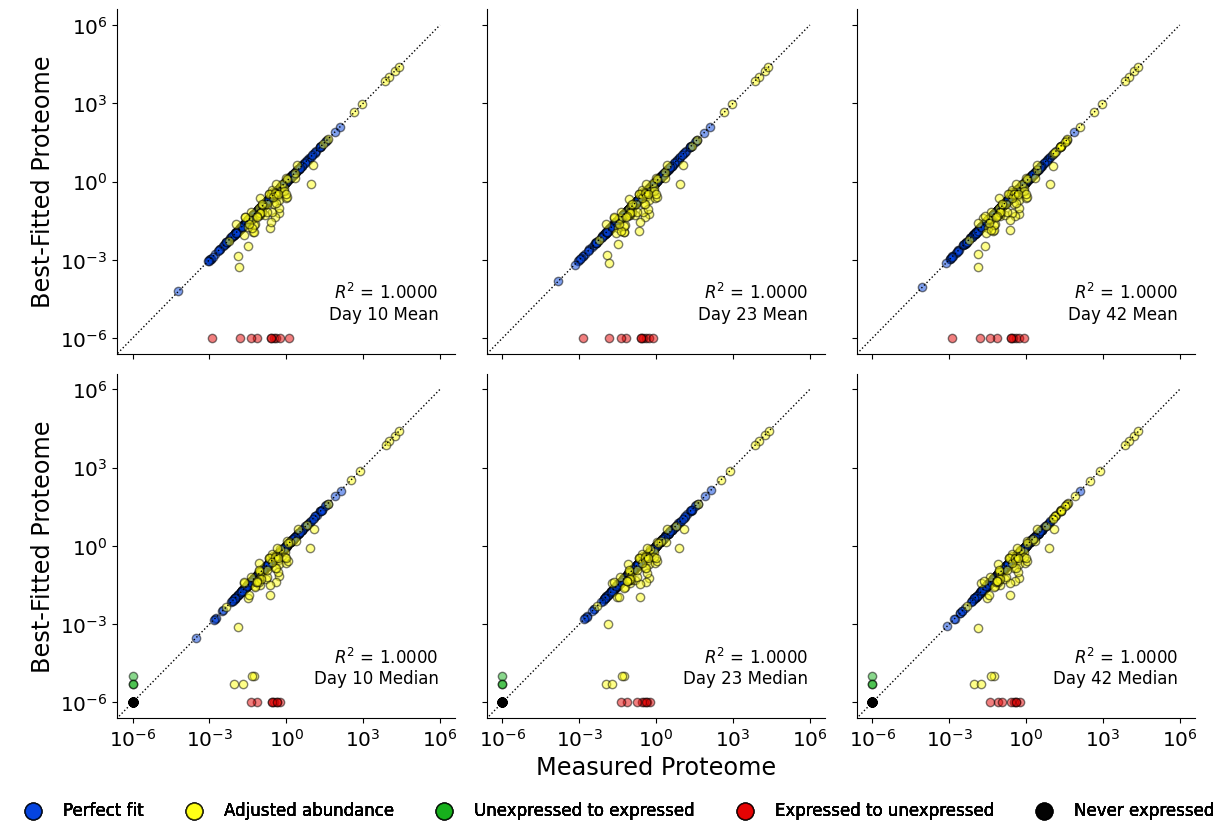

In [20]:
samples_to_plot = np.array(
    [
        # Best for 1 or 3 columns
        [x for x in operation_ids if "Mean" in x],
        [x for x in operation_ids if "Median" in x],
    ]
)

r2_text_loc = "lower right"

length = 4
nrows, ncols = samples_to_plot.shape
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(length * ncols, length * nrows),
    sharex=True,
    sharey=True,
)
sns.despine(fig)

for idx, (sample_id, ax) in enumerate(zip(samples_to_plot.flatten(), axes.flatten())):
    df_qp_sol, r2, objective_value = qp_solutions_dict[sample_id]
    xlabel, ylabel = df_qp_sol.columns

    ticks = np.geomspace(1e-6, 1e6, 5)
    perfect_fit_line = ax.plot(
        [0, ticks[-1]],
        [0, ticks[-1]],
        linestyle=":",
        color="black",
        linewidth=1,
        alpha=1,
    )

    df_zeros = df_qp_sol[(df_qp_sol.apply(lambda x: np.isclose(x, 0))).any(axis=1)]
    df_perfect = df_qp_sol[
        np.isclose(
            abs(df_qp_sol["Measured Proteome"] - df_qp_sol["Best-Fitted Proteome"]), 0
        )
    ]
    df_perfect = df_perfect[~df_perfect.index.isin(df_zeros.index)]

    df_altered = df_qp_sol[
        ~np.isclose(
            abs(df_qp_sol["Measured Proteome"] - df_qp_sol["Best-Fitted Proteome"]), 0
        )
    ]
    df_altered = df_altered[~df_altered.index.isin(df_zeros.index)]
    df_always_zero = df_zeros[(df_zeros == 0).all(axis=1)]
    df_zeros = df_zeros[~df_zeros.index.isin(df_always_zero.index)]
    df_from_zeros = df_zeros[np.isclose(df_zeros["Measured Proteome"], 0)]
    df_to_zeros = df_zeros[np.isclose(df_zeros["Best-Fitted Proteome"], 0)]

    handles = [
        ax.scatter(
            data=df_perfect.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:blue",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_altered.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:yellow",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_from_zeros.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:green",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_to_zeros.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:red",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
        ax.scatter(
            data=df_always_zero.replace(0, ticks[0]),
            x=xlabel,
            y=ylabel,
            color="xkcd:black",
            alpha=0.5,
            edgecolors="black",
            linewidths=1,
        ),
    ]
    labels = [
        f"Perfect fit",
        f"Adjusted abundance",
        f"Unexpressed to expressed",
        f"Expressed to unexpressed",
        f"Never expressed",
    ]

    donor, day = sample_id.split("_")
    if not ("Mean" == donor or "Median" == donor):
        donor = donor.replace("S", "; Donor ")
    day = day.replace("D", "Day ")
    fancy_sample_id = " ".join((day, donor))

    ax.set_xscale("log")
    ax.set_yscale("log")

    fontdict = {"size": "xx-large"}
    if idx == len(samples_to_plot.flatten()) - np.ceil(ncols / 2):
        ax.set_xlabel(xlabel, fontdict=fontdict)
    fig.legend(
        handles=handles,
        labels=labels,
        loc="lower center",
        ncols=len(labels),
        frameon=False,
        fontsize="large",
        markerscale=2,
        bbox_to_anchor=(0.5, -0.05),
    )
    if idx % ncols == 0:
        ax.set_ylabel(ylabel, fontdict=fontdict)

    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.xaxis.set_tick_params(labelsize="x-large")
    ax.yaxis.set_tick_params(labelsize="x-large")

    r2_format = " = {:.4f}"
    if r2_text_loc == "lower right":
        ax.text(
            0.95,
            0.1,
            r"$R^{2}$" + r2_format.format(r2) + ("\n{}".format(fancy_sample_id)),
            transform=ax.transAxes,
            color="black",
            fontsize="large",
            ha="right",
        )
    elif r2_text_loc == "upper left":
        ax.text(
            0.05,
            0.9,
            ("{}\n".format(fancy_sample_id)) + r"$R^{2}$" + r2_format.format(r2),
            transform=ax.transAxes,
            color="black",
            fontsize="large",
            ha="left",
        )
    else:
        pass
fig.tight_layout()
if save_figures:
    fig.savefig(
        fitting_path / f"QPfitting_{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Determine best value for slack variables

In [21]:
list_of_pcmodels = []
verbose = True
objective_rxns = ["NaKt"]

slack_min = 1e-5  # Slack %
slack_max = 1.5
if run_computations:
    for sample_id in operation_ids:
        df_qp_sol, r2, objective_value = qp_solutions_dict[sample_id]
        # Create a copy of the model
        pcmodel_sample = pcmodel.copy()
        pcmodel_sample.id = f"{pcmodel.id}_{sample_id}"
        for protdl in pcmodel_sample.reactions.query(
            lambda x: isinstance(x, ProteinDilution)
        ):
            if protdl.id in df_qp_sol.index:
                prot_bound = df_qp_sol.loc[protdl.id]["Best-Fitted Proteome"]
            else:
                prot_bound = 0
            protdl.bounds = (float(prot_bound), float(prot_bound))
        # Add the relaxation budget with slack = 0 first
        add_relaxation_budget(pcmodel_sample, 0, int(verbose))
        list_of_pcmodels += [pcmodel_sample]

    solutions = {
        pcmodel_sample.id: {
            "model": [],
            "slack": [],
            "objective": [],
            "relaxation": [],
            "_".join(objective_rxns): [],
        }
        for pcmodel_sample in list_of_pcmodels
    }
    for slack_value in np.geomspace(slack_min, slack_max, 501):
        if int(verbose):
            print(f"Updating slack variable to {100 * slack_value:.6f}%.")
        for pcmodel_sample in list_of_pcmodels:
            update_slack_value(pcmodel_sample, slack_value, verbose=False)
            relaxation_demand = pcmodel_sample.reactions.get_by_id(
                f"PBDL_relaxation_budget"
            )
            pcmodel_sample.objective = (
                sum(
                    [
                        r.flux_expression
                        for r in pcmodel_sample.reactions.get_by_any(objective_rxns)
                    ]
                )
                - relaxation_demand.flux_expression
            )
            pcmodel_sample.objective_direction = "max"
            sol = pcmodel_sample.optimize()
            obj_value = sol.objective_value
            if not obj_value or np.isnan(obj_value):
                if int(verbose) > 1:
                    print(f"No solution for {100 * slack_value:.6f}%\n.")
                continue
            else:
                demand = relaxation_demand.flux
                budget = relaxation_demand.upper_bound
            solutions[pcmodel_sample.id]["model"].append(pcmodel_sample.id)
            solutions[pcmodel_sample.id]["slack"].append(slack_value)
            solutions[pcmodel_sample.id]["objective"].append(obj_value)
            solutions[pcmodel_sample.id]["_".join(objective_rxns)].append(
                obj_value + demand
            )
            solutions[pcmodel_sample.id]["relaxation"].append(demand / budget)
    solutions = {
        pcmodel_sample_id: pd.DataFrame.from_dict(sol)
        for pcmodel_sample_id, sol in solutions.items()
    }
    solutions = {
        pcmodel_sample: pd.DataFrame.from_dict(sol)
        for pcmodel_sample, sol in solutions.items()
    }

    df_relaxation = pd.concat(list(solutions.values()), axis=0)
    df_relaxation.to_csv(
        fitting_path / f"SlackPercentDeterminationData_{model_id}.tsv",
        sep="\t",
        index=False,
    )
else:
    df_relaxation = pd.read_csv(
        fitting_path / f"SlackPercentDeterminationData_{model_id}.tsv", sep="\t"
    )
    solutions = {
        mid: df_relaxation[df_relaxation["model"] == mid].drop("model", axis=1)
        for mid in df_relaxation["model"].unique()
    }
df_relaxation

,model,slack,objective,relaxation,NaKt
0,RBC_GEM_PC_Mean_D10,0.020061,-0.849103,0.048571,0.100477
1,RBC_GEM_PC_Mean_D10,0.020545,-0.847771,0.047360,0.100477
2,RBC_GEM_PC_Mean_D10,0.021040,-0.846385,0.046177,0.100477
3,RBC_GEM_PC_Mean_D10,0.021548,-0.844942,0.045021,0.100477
4,RBC_GEM_PC_Mean_D10,0.022068,-0.843442,0.043890,0.100477
...,...,...,...,...,...
1087,RBC_GEM_PC_Median_D42,1.363586,0.025675,0.000052,0.094861
1088,RBC_GEM_PC_Median_D42,1.396480,0.025675,0.000051,0.094861
1089,RBC_GEM_PC_Median_D42,1.430167,0.025675,0.000050,0.094861
1090,RBC_GEM_PC_Median_D42,1.464668,0.025675,0.000048,0.094861


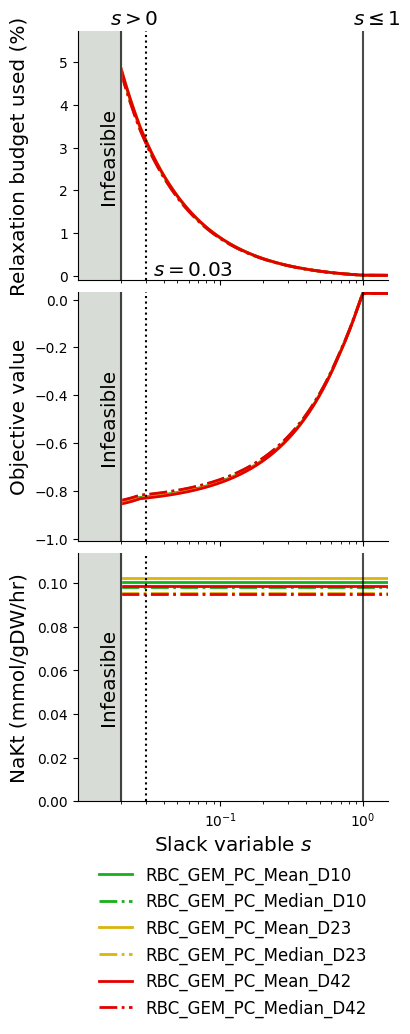

In [22]:
fig, axes = plt.subplots(
    3, 1, figsize=(4, 10), sharex=True, gridspec_kw=dict(hspace=0.05)
)
axes = axes.flatten()

# ax3d = fig.add_subplot(2, 2, 4, projection="3d")
sns.despine(fig)

handles = []
labels = []
chosen_slack_var = 0.03
colors = {
    "D10": "xkcd:green",
    "D23": "xkcd:gold",
    "D42": "xkcd:red",
}
linestyles = {
    "Mean": "-",
    "Median": "-.",
}
use_percents = True
for pcmodel_sample in list(solutions):
    donor, day = str(pcmodel_sample).split("_")[-2:]
    linestyle = linestyles.get(donor, ":")
    color = colors.get(day, "xkcd:light blue")
    if not ("Mean" == donor or "Median" == donor):
        donor = donor.replace("S", "; Donor ")
    day = day.replace("D", "Day ")
    fancy_sample_id = " ".join((day, donor))

    labels.append(fancy_sample_id)
    s_values = solutions[str(pcmodel_sample)]["slack"].values
    r_values = solutions[str(pcmodel_sample)]["relaxation"].values * (
        100 if use_percents else 1
    )
    o_values = solutions[str(pcmodel_sample)]["objective"].values
    rxn_values = solutions[str(pcmodel_sample)]["_".join(objective_rxns)].values

    zorder = 1
    lw = 2
    axes[0].plot(
        s_values,
        r_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )
    axes[1].plot(
        s_values,
        o_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )
    axes[2].plot(
        s_values,
        rxn_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )

    # index = list(s_values).index(s_values[s_values >= chosen_slack_var][0])
    # spt = s_values[index]
    # rpt = r_values[index]
    # opt = o_values[index]
    # rxnpt = rxn_values[index]
    # c = "black"
    # ls = ""
    # marker = "o"
    # markersize = 8
    # axes[0].plot(spt, rpt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # axes[1].plot(spt, opt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # axes[2].plot(spt, rxnpt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # ax3d.plot(spt, rpt, opt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # print(f"Elbow point for {pcmodel_sample}: ({spt:.5f}, {rpt:.5f}, {opt:.5f})")
fontdict = {"size": "x-large"}
axes[-1].set_xlabel(r"Slack variable $s$", fontdict=fontdict)

zorder = 2
alpha = 0.7
limit_pad_sclar = 1.2
smin = s_values[0]

for i, ax in enumerate(axes):
    if i == 0:
        ymin, ymax = (-0.001 * (100 if use_percents else 1), max(r_values) * limit_pad_sclar)
    elif i == 1:
        ymin, ymax = (min(0, min(o_values)) * limit_pad_sclar, max(o_values) * limit_pad_sclar)
    elif i == 2:
        ymin, ymax = (0, max(rxn_values) * limit_pad_sclar)
    else:
        pass
    ax.vlines(chosen_slack_var, ymin=ymin, ymax=ymax, color="black", linestyle=":")
    ax.vlines(
        smin, ymin=ymin, ymax=ymax, color="black", linestyle="-", zorder=zorder, alpha=alpha
    )
    ax.vlines(
        1, ymin=ymin, ymax=ymax, color="black", linestyle="-", zorder=zorder, alpha=alpha
    )
    ax.set_xlim(smin / 2, slack_max)
    ax.set_ylim(ymin, ymax)
    ax.set_xscale("log")    
    if i == 0:
        ax.annotate(
            rf"$s > 0$",
            xy=(smin, ymax),
            xycoords="data",
            xytext=(10, 5),
            textcoords="offset points",
            ha="center",
            fontsize=fontdict["size"],
        )
        ax.annotate(
            rf"$s \leq 1$",
            xy=(1, ymax),
            xycoords="data",
            xytext=(10, 5),
            textcoords="offset points",
            ha="center",
            fontsize=fontdict["size"],
        )
        ax.annotate(
            rf"$s = {chosen_slack_var}$",
            xy=(chosen_slack_var, 0),
            xycoords="data",
            xytext=(5, 0),
            textcoords="offset points",
            ha="left",
            fontsize=fontdict["size"],
        )
    ax.fill_between((smin / 2, smin), ymin, ymax, color="xkcd:light grey")
    ax.annotate(
        "Infeasible",
        xy=(smin, (ymax + ymin) / 2),
        xycoords="data",
        rotation=90,
        xytext=(-2, 0),
        textcoords="offset points",
        va="center",
        ha="right",
        fontsize=fontdict["size"],
    )


handles, labels = axes[2].get_legend_handles_labels()
axes[2].legend(
    handles=handles,
    labels=labels,
    ncols=1,
    frameon=False,
    loc="upper center",
    fontsize="large",
    bbox_to_anchor=(0.5, -0.2),
)


axes[0].set_ylabel("Relaxation budget used (%)", fontdict=fontdict)
axes[1].set_ylabel("Objective value", fontdict=fontdict)
axes[2].set_ylabel("NaKt (mmol/gDW/hr)", fontdict=fontdict)

fig.align_labels()
if save_figures:
    fig.savefig(
        fitting_path / f"SlackPercentDetermination_{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Formulate models from QP solutions

In [23]:
list_of_relaxed_models = []
slack_value = chosen_slack_var  # Slack %
verbose = True

# In our experience, SBML/XML loads faster, but will take up to 4x more space uncompressed as compared to JSON
ftypes = {
    "xml"
    # "json",
}

model_values = {}
dataset_sample_models_dirpath.mkdir(exist_ok=True, parents=True)
ftypes = set([ftypes]) if isinstance(ftypes, str) else set(ftypes)
for sample_id, (df_qp_sol, r2, objective_value) in qp_solutions_dict.items():
    # Create a copy of the model
    sample_id = f"{pcmodel.id}_{sample_id}"
    filenames = [dataset_sample_models_dirpath / f"{sample_id}.{ftype}" for ftype in ftypes]
    if all([filename.exists() for filename in filenames]):
        print(f"Model already created for {sample_id}")
        continue
    pcmodel_sample = pcmodel.copy()
    pcmodel_sample.id = sample_id
    for protdl in pcmodel_sample.reactions.query(
        lambda x: isinstance(x, ProteinDilution)
    ):
        if protdl.id in df_qp_sol.index:
            prot_bound = df_qp_sol.loc[protdl.id]["Best-Fitted Proteome"]
        else:
            prot_bound = 0
        protdl.bounds = (float(prot_bound), float(prot_bound))
    # Add the relaxation budget
    add_relaxation_budget(pcmodel_sample, slack_value, verbose)
    # # Store model for later use
    # list_of_relaxed_models += [pcmodel_sample]
    for filename in filenames:
        # Might as well overwrite all files, especially if model needed to be regenerated anyways
        write_cobra_model(
            pcmodel_sample,
            filename=filename,
        )

Model already created for RBC_GEM_PC_S001_D10
Model already created for RBC_GEM_PC_S001_D23
Model already created for RBC_GEM_PC_S001_D42
Model already created for RBC_GEM_PC_S002_D10
Model already created for RBC_GEM_PC_S002_D23
Model already created for RBC_GEM_PC_S002_D42
Model already created for RBC_GEM_PC_S003_D10
Model already created for RBC_GEM_PC_S003_D23
Model already created for RBC_GEM_PC_S003_D42
Model already created for RBC_GEM_PC_S004_D10
Model already created for RBC_GEM_PC_S004_D23
Model already created for RBC_GEM_PC_S004_D42
Model already created for RBC_GEM_PC_S005_D10
Model already created for RBC_GEM_PC_S005_D23
Model already created for RBC_GEM_PC_S005_D42
Model already created for RBC_GEM_PC_S006_D10
Model already created for RBC_GEM_PC_S006_D23
Model already created for RBC_GEM_PC_S006_D42
Model already created for RBC_GEM_PC_S007_D10
Model already created for RBC_GEM_PC_S007_D23
Model already created for RBC_GEM_PC_S007_D42
Model already created for RBC_GEM_